# Demographics Data

Marketing Database.

Source: Impact Resources, Inc., Columbus, OH (1987). 

A total of N=9409 questionnaires containg 502 questions were filled out by shopping mall customers in the San Francisco Bay area. 

The dataset is an extract from this survey. It consists of 14 demographic attributes. The dataset is a good mixture of categorical and continuos variables with a lot of missing data. This is characteristic 
for data mining applications. 

Variables:

|         |                                                                  |
|---------|------------------------------------------------------------------|
|income   |ANNUAL INCOME OF HOUSEHOLD<br>(PERSONAL INCOME IF SINGLE)         |
|sex      |SEX                                                               |
|mar-stat |MARITAL STATUS                                                    |
|age      |AGE                                                               |
|edu      |EDUCATION                                                         |
|occup    |OCCUPATION                                                        |
|yrs-BA   |HOW LONG HAVE YOU LIVED IN THE<br>SAN FRAN./OAKLAND/SAN JOSE AREA?|
|mar-dlinc|DUAL INCOMES (IF MARRIED)                                         |
|num-hsld |PERSONS IN YOUR HOUSEHOLD                                         |
|children |PERSONS IN HOUSEHOLD UNDER 18                                     |
|hsld-stat|HOUSEHOLDER STATUS                                                |
|typ-home |TYPE OF HOME                                                      |
|ethnic   |ETHNIC CLASSIFICATION                                             |
|lang     |WHAT LANGUAGE IS SPOKEN MOST<br>OFTEN IN YOUR HOME?               |

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/Demographis.txt", sep=';')
df.iloc[0]  # use df.head() instead

income               $75,000 or more
sex                           Female
mar-stat                     Married
age                       45 thru 54
edu          1 to 3 years of college
occup                      Homemaker
yrs-BA           More than ten years
mar-dlinc                         No
num-hsld                       Three
children                        None
hsld-stat                        Own
typ-home                       House
ethnic                         White
lang                             NaN
Name: 0, dtype: object

### Treat Missing Values

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
# replace missing values with most frequent observations
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

### Treat Ordered Categorical Features

In [5]:
# Convert ordered categorical (ordinal) features to quantitative.
# The values of this type of variable are often represented
# as contiguous integers (1-N), but I prefer 'natural' values.
# It doesn't affect the result, but the plots are easier to read
income_cats = {
    'Less than $10,000':  5000,  '$10,000 to $14,999': 12500,
    '$15,000 to $19,999': 17500, '$20,000 to $24,999': 22500,
    '$25,000 to $29,999': 27500, '$30,000 to $39,999': 35000,
    '$40,000 to $49,999': 45000, '$50,000 to $74,999': 62500,
    '$75,000 or more': 100000}

age_cats = {
    '14 thru 17': 15, '18 thru 24': 21, '25 thru 34': 30,
    '35 thru 44': 40, '45 thru 54': 50, '55 thru 64': 60,
    '65 and Over': 70}

yrs_BA_cats = {
    'Less than one year': 0.5, 'One to three years': 2,
    'Four to six years': 5,    'Seven to ten years': 8,
    'More than ten years': 15}

num_hsld_cats = {
    'One': 1, 'Two': 2,   'Three': 3, 'Four': 4, 'Five': 5,
    'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine or more': 10}

children_cats = {
    'None': 0, 'One': 1, 'Two': 2,   'Three': 3, 'Four': 4,
    'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine or more': 10}

# do replacement
df.replace({
    'income': income_cats,
    'age': age_cats,
    'yrs-BA': yrs_BA_cats,
    'num-hsld': num_hsld_cats,
    'children': children_cats
}, inplace=True)

### Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
target = 'occup'
features = [
    'income', 'sex', 'mar-stat', 'age', 'edu', 'yrs-BA', 'mar-dlinc',
    'num-hsld', 'children', 'hsld-stat', 'typ-home', 'ethnic', 'lang']
cat_features = [
    'sex', 'mar-stat', 'mar-dlinc', 'edu',
    'hsld-stat', 'ethnic', 'lang', 'typ-home']

X, y = df[features].values, df[target].values

# PAGE 379. We randomly divided the data into a training set (80%) 
#           and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

## Base Model

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [9]:
# PAGE 379. ...the null rate of 69% obtained by predicting the most
#           numerous class Prof/Man (Professional/Managerial).
dummy_clf = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
y_test_hat = dummy_clf.predict(X_test)
dummy_error_rate = 1 - accuracy_score(y_test, y_test_hat)
print(f'The null error rate {dummy_error_rate:.2f}')

The null error rate 0.69


## Boosting over Decision Trees

In [10]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import confusion_matrix

In [11]:
# CatBoost uses the indices of categorical features
cat_features_idx = [features.index(f) for f in cat_features]

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features_idx)

eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_features_idx)

In [12]:
model = CatBoostClassifier(
    iterations=350,
    learning_rate=0.035,
    loss_function='MultiClass',
    eval_metric='Accuracy'
).fit(
    train_dataset,
    use_best_model=True,
    eval_set=eval_dataset,
    verbose=False,
    plot=False  # set it True to track training progress
)

### Model Performance

In [13]:
# PAGE 379. The overall error rate is 42.5% ... The four best predicted
#           classes are seen to be Retired, Student, Prof/Man, and Homemaker.
y_test_hat = model.predict(X_test)
overall_error_rate = 1 - accuracy_score(y_test, y_test_hat)
occupations = list(set(y))
cm = confusion_matrix(y_test, y_test_hat, labels=occupations)
occup_error_rates = 1 - cm.diagonal()/cm.sum(axis=1)
errors = sorted(zip(occup_error_rates, occupations))

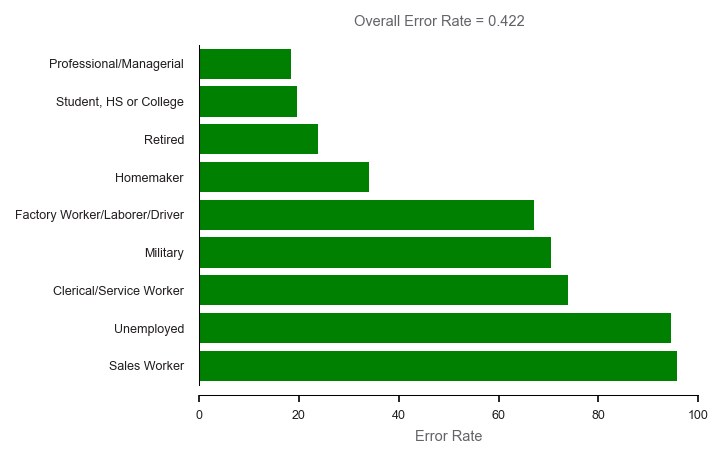

In [14]:
# PAGE 381. FIGURE 10.22. Error rate for each occupation in the demographics
#           data.
yticks = np.arange(len(errors))
yticklabels = [e[1] for e in errors][::-1]
bars_sizes = [100*e[0] for e in errors][::-1]

fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
bars = ax.barh(yticks, bars_sizes, height=0.8, color='green')
plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
ax.set_xlim([0, 100])
ax.set_ylim([-0.5, 8.5])
for e in ax.get_yticklabels()+ax.get_xticklabels():
    e.set_fontsize(6)
    e.set_color(GRAY1)
ax.tick_params(left=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
         [ax.spines['bottom']]:
    e.set_transform(e.get_transform() + offset)
ax.spines['bottom'].set_bounds(0, 100)
ax.text(31, 9, f'Overall Error Rate = {overall_error_rate:.3f}',
        color=GRAY4, fontsize=7)
_ = ax.set_xlabel('Error Rate', color=GRAY4, fontsize=7)

### Relative Importance of the Predictors

In [15]:
# we'll construct many plots, so let's implement a function
def plot_importance_bars(ax, model, title=None):
    importance = np.array(model.get_feature_importance())
    max_importance = np.max(importance)
    relative_importance = sorted(zip(100*importance/max_importance, features))

    yticks = np.arange(len(relative_importance))
    yticklabels = [ri[1] for ri in relative_importance][::-1]
    bars_sizes = [ri[0] for ri in relative_importance][::-1]

    bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
    plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.5, len(relative_importance) - 0.5])
    for e in ax.get_yticklabels()+ax.get_xticklabels():
        e.set_fontsize(6)
        e.set_color(GRAY1)
    ax.tick_params(left=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
    for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
            [ax.spines['bottom']]:
        e.set_transform(e.get_transform() + offset)
    ax.spines['bottom'].set_bounds(0, 100)
    ax.set_xlabel('Relative Importance', color=GRAY4, fontsize=7)
    if title is not None:
        ax.text(50, ax.get_ylim()[1]+0.5, title, color=GRAY4, fontsize=8,
                horizontalalignment='center')

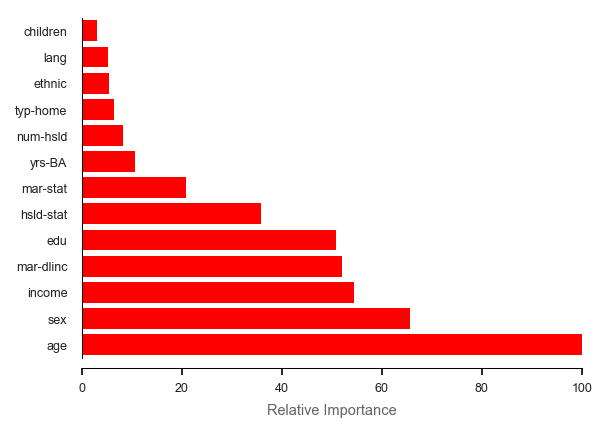

In [16]:
# PAGE 381. FIGURE 10.23. Relative importance of the predictors as
#           averaged over all classes for the demographics data.
fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
plot_importance_bars(ax, model)

## One-Vs-Rest Classification

In [17]:
# trains a boosting model for the specified occupation
def build_model(occupation):
    y_train_occup = 0 + (y_train == occupation)
    y_test_occup = 0 + (y_test == occupation)
    train_dataset = Pool(data=X_train,
                         label=y_train_occup,
                         cat_features=cat_features_idx)
    eval_dataset = Pool(data=X_test,
                        label=y_test_occup,
                        cat_features=cat_features_idx)
    model = CatBoostClassifier(
        iterations=350,
        learning_rate=0.035,
        eval_metric='Accuracy'
    ).fit(
        train_dataset,
        use_best_model=True,
        eval_set=eval_dataset,
        verbose=False
    )
    return model

In [18]:
# train 4 models
retired_clf = build_model('Retired')
prof_man_clf = build_model('Professional/Managerial')
student_clf = build_model('Student, HS or College')
homemaker_clf = build_model('Homemaker')

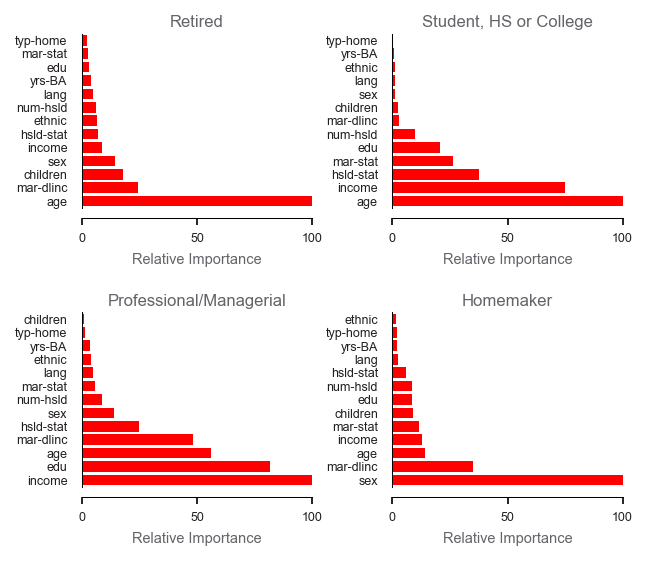

In [19]:
# PAGE 382. FIGURE 10.24. Predictor variable importance separately for each of
#           the four classes with lowest error rate for the demographics data.
fig, axarr = plt.subplots(2, 2, figsize=(4.65, 4), dpi=150)
plt.subplots_adjust(wspace=0.35, hspace=0.6)
plot_importance_bars(axarr[0, 0], retired_clf, 'Retired')
plot_importance_bars(axarr[0, 1], student_clf, 'Student, HS or College')
plot_importance_bars(axarr[1, 0], prof_man_clf, 'Professional/Managerial')
plot_importance_bars(axarr[1, 1], homemaker_clf, 'Homemaker')

In [20]:
# PAGE 380. Figure 10.25 shows the partial dependance of the log-odds (10.25)
#           on age for these three classes.
# PAGE 380. One sees that after accounting for the contribution of the other
#           variables, the odds of being retired are higher for older people,
#           whereas the opposite is the case for being a student.
def plot_partial_dependence(ax, model, occupation):
    prior_prob = np.mean(0 + (y == occupation))
    coef = (1 - prior_prob)/prior_prob
    n = features.index('age')
    X_tmp = X.copy()
    vals = np.unique(X_tmp[:, n])
    result = []
    for i in range(vals.shape[0]):
        X_tmp[:, n] = vals[i]
        pr = np.mean(model.predict_proba(X_tmp), axis=0)
        result.append(np.log(coef*pr[1]/pr[0]))
    ax.plot(vals, result, linewidth=0.6, color='#26FF26')
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(4)
    ax.set_ylabel('Partial Dependance', color=GRAY4, fontsize=6)
    ax.set_xlabel('age', color=GRAY4, fontsize=6)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.set_ylim(-3.5, 3.5)
    ax.text(
        np.mean(ax.get_xlim()), ax.get_ylim()[1]+0.5,
        occupation, color=GRAY4, fontsize=7,
        horizontalalignment='center')

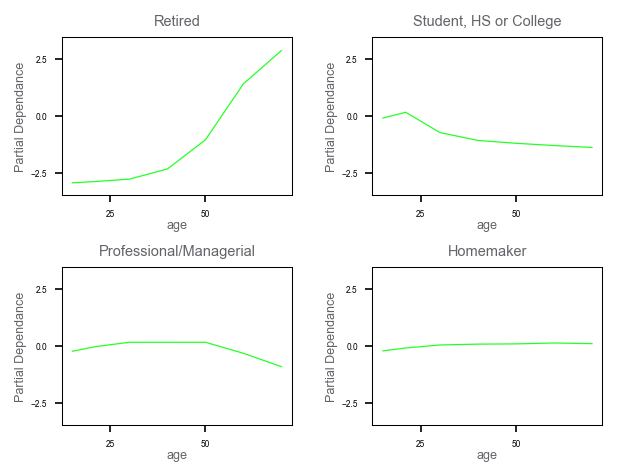

In [21]:
# PAGE 383. FIGURE 10.25. Partial dependance of the odds of three different
#           occupations on age, for the demographics data.
fig, axarr = plt.subplots(2, 2, figsize=(4.65, 3.43), dpi=150)
plt.subplots_adjust(wspace=0.35, hspace=0.45)
plot_partial_dependence(axarr[0, 0], retired_clf, 'Retired')
plot_partial_dependence(axarr[0, 1], student_clf, 'Student, HS or College')
plot_partial_dependence(axarr[1, 0], prof_man_clf, 'Professional/Managerial')
plot_partial_dependence(axarr[1, 1], homemaker_clf, 'Homemaker')

# Market Basket Analysis

In [22]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Reload and Prepare Data

In [23]:
df = pd.read_csv("../data/Demographis.txt", sep=';')
# PAGE 492. After removing observations with missing values, each ordinal
#           predictor was cut at its median and coded by two dummy variables;
#           each categorical predictor with k categories was coded by k dummy
#           variables.
df.dropna(inplace=True)

# treat ordinal features
ordinal = ['income', 'age', 'edu', 'yrs-BA', 'num-hsld', 'children']
income_order = [
    'Less than $10,000', '$10,000 to $14,999', '$15,000 to $19,999',
    '$20,000 to $24,999', '$25,000 to $29,999', '$30,000 to $39,999',
    '$40,000 to $49,999', '$50,000 to $74,999', '$75,000 or more']
age_order = sorted(list(set(df.age)))
edu_order = [
    'Grade 8 or less', 'Grades 9 to 11', 'Graduated high school',
    '1 to 3 years of college', 'College graduate', 'Grad Study']
yrs_BA_order = [
    'Less than one year', 'One to three years', 'Four to six years',
    'Seven to ten years', 'More than ten years']
num_hsld_order = [
    'One', 'Two', 'Three', 'Four', 'Five',
    'Six', 'Seven', 'Eight', 'Nine or more']
children_order = [
    'None', 'One', 'Two', 'Three', 'Four', 'Five',
    'Six', 'Seven', 'Eight', 'Nine or more']
orders = [income_order, age_order, edu_order,
          yrs_BA_order, num_hsld_order, children_order]
orders_dict = [{i: e for i, e in enumerate(o)} for o in orders]

# find medians for all ordinal features
for name, order, mapper in zip(ordinal, orders, orders_dict):
    vals = df.groupby(name)[name].count().apply(mapper).values
    median_index = np.argwhere(np.cumsum(vals) > np.sum(vals)//2)[0, 0]
    print(f'{name:<10} {median_index} {order[median_index]:>25}')

income     5        $30,000 to $39,999
age        2                25 thru 34
edu        3   1 to 3 years of college
yrs-BA     4       More than ten years
num-hsld   2                     Three
children   0                      None


In [24]:
# PAGE 495. As stated above, we created dummy variables for each category of
#           the input predictors, for example, Z1 = I(income < $40, 000) and
#           Z2 = I(income ≥ $40, 000) for below and above the median income. If
#           we were interested only in finding associations with the
#           high-income category, we would include Z2 but not Z1. This is often
#           the case in actual market basket problems, where we are interested
#           in finding associations with the presence of a relatively rare
#           item, but not associations with its absence.
splits = [
    (5, '<$40,000', '>=$40,000'),
    (2, 'yonger 35', '35 and older'),
    (3, 'NOT {college graduate, graduate study}',
        '{college graduate, graduate study}'),
    (3, '<= 10 years in BA', 'more 10 years in BA'),
    (2, '<= 3 persons in household', '> 3 persons in household'),
    (0, 'no chidren', 'has kids')]
for name, order, split in zip(ordinal, orders, splits):
    mapper = {e: split[1+(i > split[0])] for i, e in enumerate(order)}
    df[name] = df[name].map(mapper)

# convert to dummy features
df_dummy = pd.get_dummies(df)

In [25]:
# PAGE 492. This resulted in a 6876 × 50 matrix of 6876 observations
#           on 50 dummy variables.
print(f'{len(df_dummy)} x {len(df_dummy.columns)}')

6876 x 50


## Apriori

In [26]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [27]:
# PAGE 492. The algorithm found a total of 6288 association rules,
#           involving ≤ 5 predictors, with support of at least 10%.
frequent_itemsets = apriori(df_dummy, min_support=0.12, use_colnames=True)
rules = association_rules(frequent_itemsets)
# remove obvious rules
rules = rules[rules.confidence < 1]

In [28]:
# PAGE 492. We will not attempt this here, but only illustrate in Figure 14.2
#           the relative frequency of each dummy variable in the data (top) and
#           the association rules (bottom). Prevalent categories tend to appear
#           more often in the rules, for example, the first category in
#           language (English). However, others such as occupation are
#           under-represented, with the exception of the first and fifth level.
dummy_variables = df_dummy.columns
dummy_variables_types = [d[:d.index('_')] for d in dummy_variables]
rel_frequency = np.sum(df_dummy.values, axis=0) / np.sum(df_dummy.values)

In [29]:
rule_frequency = np.zeros(shape=(len(dummy_variables)))
dummy_in_rules = rules[['antecedents', 'consequents']].values
for i in range(len(dummy_variables)):
    var = dummy_variables[i]
    for j in range(dummy_in_rules.shape[0]):
        rule_frequency[i] += (var in dummy_in_rules[j, 0]) + \
                             (var in dummy_in_rules[j, 1])
rule_frequency /= sum(rule_frequency)

In [30]:
def plot_freq(ax, freq, xlim, xlabel):
    ax.barh(range(len(dummy_variables)), freq)
    ax.set_ylim(49.5, -0.5)
    ax.set_xlim(0, xlim)

    plt.setp(ax, yticks=np.linspace(0, len(dummy_variables), 6))

    prev_line = -0.5
    for i in range(1, len(dummy_variables)):
        if dummy_variables_types[i-1] != dummy_variables_types[i]:
            ax.axhline(i-0.5, color=GRAY4, linewidth=0.5)
            curr_line = i-0.5
            ax.text(xlim*1.07, (prev_line + curr_line)/2,
                    dummy_variables_types[i-1], color=GRAY4, size=8)
            prev_line = curr_line
    ax.text(xlim*1.07, (prev_line + 49.5)/2,
            dummy_variables_types[-1], color=GRAY4, size=8)

    ax.tick_params(top='on', bottom='off', labelbottom='off', labeltop='on')

    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_color(GRAY7)

    # remove chart border
    ax.tick_params(color=GRAY7)
    ax.spines['top'].set_color(GRAY7)
    ax.spines['left'].set_color(GRAY7)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    offset = transforms.ScaledTranslation(0, 0.03, fig.dpi_scale_trans)
    for item in [ax.spines['top']] + ax.get_xticklabels() + \
                ax.xaxis.get_ticklines():
        item.set_transform(item.get_transform() + offset)
    offset = transforms.ScaledTranslation(-0.03, 0, fig.dpi_scale_trans)
    for item in [ax.spines['left']] + ax.get_yticklabels() + \
                ax.yaxis.get_ticklines():
        item.set_transform(item.get_transform() + offset)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(xlabel, color=GRAY4, fontsize=8)
    ax.set_ylabel('Attribute', color=GRAY4, fontsize=8)

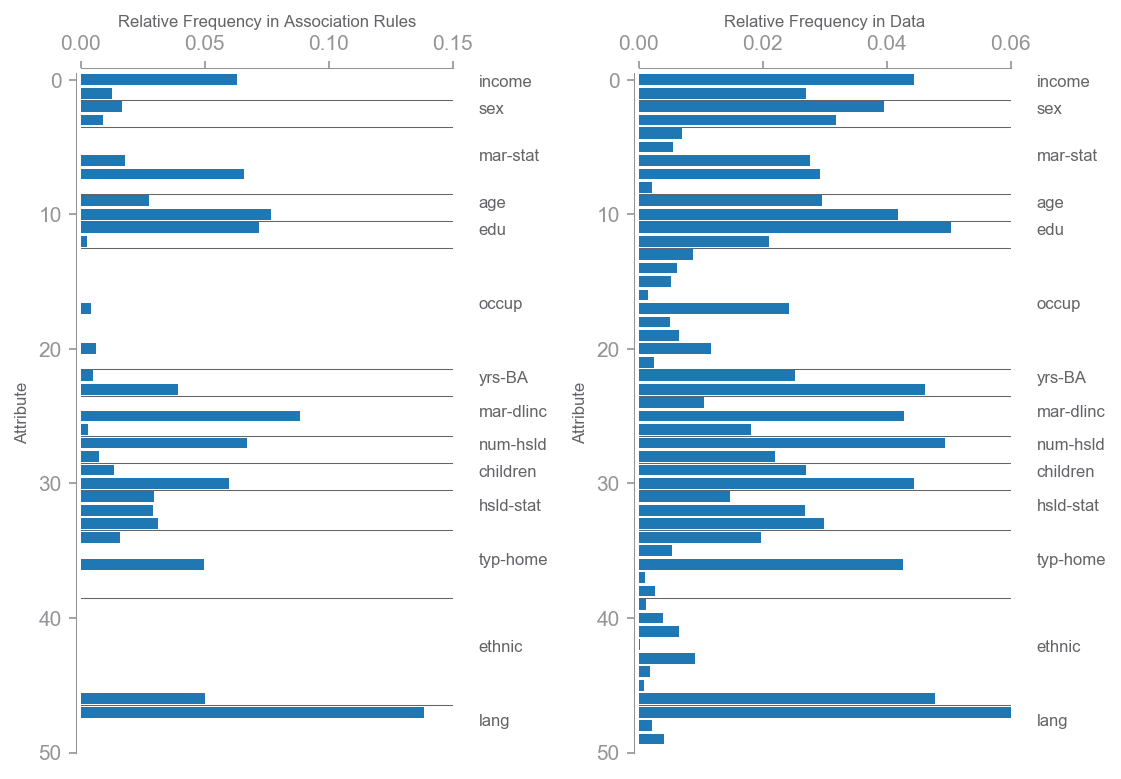

In [31]:
# PAGE 493. FIGURE 14.2. Market basket analysis: relative frequency of each
#           dummy variable (coding an input category) in the data (top), and
#           the association rules found by the Apriori algorithm (bottom).
fig, axarr = plt.subplots(1, 2, figsize=(8, 6), dpi=150)
fig.subplots_adjust(wspace=0.5)
plot_freq(
    axarr[0], rule_frequency, 0.15, 'Relative Frequency in Association Rules')
plot_freq(axarr[1], rel_frequency, 0.06, 'Relative Frequency in Data')

In [32]:
# PAGE 495. We chose the first and third rules based on their high support.
len2_filter = rules.antecedents.str.len() == 2
print('\nRule 1\n')
print(rules[len2_filter].sort_values('support', ascending=[0]).iloc[0])
print('\nRule 3\n')
len4_filter = rules.antecedents.str.len() == 4
print(rules[len4_filter].sort_values('support', ascending=[0]).iloc[0])


Rule 1

antecedents           (num-hsld_<= 3 persons in household, lang_Engl...
consequents                                       (children_no chidren)
antecedent support                                             0.649506
consequent support                                             0.621873
support                                                        0.521379
confidence                                                     0.802732
lift                                                            1.29083
leverage                                                       0.117469
conviction                                                      1.91682
Name: 555, dtype: object

Rule 3

antecedents           (mar-dlinc_Not Married, income_<$40,000, age_y...
consequents                            (mar-stat_Single, never married)
antecedent support                                             0.320099
consequent support                                             0.409104
support              

In [33]:
# PAGE 495. The second rule is an association rule with a high-income
#           consequent, and could be used to try to target high-income
#           individuals.
high_income = ['income_>=$40,000' in r for r in rules.consequents.values]
print('\nRule 2\n')
print(rules[high_income].iloc[5])


Rule 2

antecedents           (occup_Professional/Managerial, hsld-stat_Own,...
consequents                                          (income_>=$40,000)
antecedent support                                             0.165503
consequent support                                             0.377545
support                                                        0.133653
confidence                                                     0.807557
lift                                                            2.13897
leverage                                                      0.0711684
conviction                                                      3.23449
Name: 1109, dtype: object
